# Основы анализа данных в Python

*Алла Тамбовцева*

## Практикум: метод k-ближайших соседей (работа с изображениями)

**Глобальная задача:** используя метод k-ближайших соседей, научиться классифицировать изображения, отличая картинки с чайками от картинок с пингвинами.

**Локальные задачи:**

* научиться преобразовывать изображения в числовые массивы (входная переменная `X` – характеристики изображения);
* закодировать изображения двумя классами *Gull* и *Penguin* (целевая переменная `Y` – класс изображения);
* обучить алгоритм методом k-ближайших соседей для предсказания класса `Y` на основе данных `X` на обучающих данных;
* оценить качество полученной модели на тестовых данных.

### Подготовка к работе

Загрузим необходимые модули и библиотеки для работы:

* модуль `os` для работы с файлами и папками, от *operating system*;
* библиотека `numpy` для работы с массивами и конвертации изображения в числовой массив;
* класс функций `Image` из библиотеки `PIL` для работы с изображениями, от *Python Imaging Library*.

Если `Image` не импортируется, установить библиотеку можно через `!pip install Pillow`.

In [2]:
import os
import numpy as np
from PIL import Image

### Знакомство с данными

Сохраним и распакуем zip-архивы:

* `train_seagull.zip`: изображения с чайками для обучения алгоритма;
* `train_penguin.zip`: изображения с пингвинами для обучения алгоритма;
* `test_seagull.zip`: изображения с чайками для тестирования качества;
* `test_penguin.zip`: изображения с пингвинами для тестирования качества.

Нужно, чтобы в одной папке лежал текущий файл `practice_knn_images.ipynb` и папки `train_seagull`, `train_penguin`, `test_seagull`, `test_penguin` (папке, не *zip*). Проще всего распаковать архивы в одной папке, туда же поместить ipynb-файл и прейти в эту папку через главную страницу Jupyter (*Home*).

Посмотрим на одно из изображений в папке `train_seagull`:

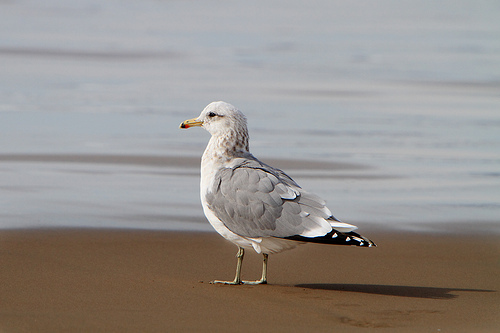

In [3]:
# на Windows могло распаковаться как папка в папке, если файл не найден, то
# путь train_seagull/train_seagull/California_Gull_0001_40786.jpg

image01 = Image.open('train_seagull/California_Gull_0001_40786.jpg')
image01

Посмотрим на его характеристики (формат, размер в пикселях и цветовая модель):

In [4]:
print(image01.format)
print(image01.size)
print(image01.mode)

JPEG
(500, 333)
RGB


Итак, это графический файл JPEG размера 500 на 333 пикселей в цветой схеме RGB. Попробуем преобразовать изображение в числовой массив `numpy` с помощью знакомой функции `.array()`:

In [5]:
# знакомая функция array()

np_img01 = np.array(image01, dtype = float)

print(np_img01.shape)
print(np_img01)

(333, 500, 3)
[[[159. 160. 165.]
  [160. 161. 166.]
  [161. 162. 167.]
  ...
  [164. 174. 176.]
  [162. 171. 176.]
  [162. 171. 176.]]

 [[161. 162. 167.]
  [161. 162. 167.]
  [161. 162. 167.]
  ...
  [163. 173. 175.]
  [162. 172. 174.]
  [162. 171. 176.]]

 [[163. 164. 168.]
  [163. 164. 169.]
  [162. 163. 168.]
  ...
  [163. 173. 175.]
  [163. 173. 175.]
  [162. 171. 176.]]

 ...

 [[117.  93.  67.]
  [119.  95.  69.]
  [116.  92.  66.]
  ...
  [127. 103.  77.]
  [124. 104.  77.]
  [124. 104.  77.]]

 [[119.  95.  71.]
  [120.  96.  70.]
  [117.  93.  67.]
  ...
  [127. 103.  75.]
  [125. 104.  75.]
  [124. 105.  75.]]

 [[120.  96.  72.]
  [120.  96.  70.]
  [118.  94.  68.]
  ...
  [126. 102.  74.]
  [124. 103.  74.]
  [124. 103.  74.]]]


Получили сложный массив из чисел, на который можно смотреть как на таблицу из 333 строк, 500 столбцов, где на пересечении каждой строки и столбца стоит список из трёх чисел – характеристик цвета в формате RGB (от *red-green-blue*, интенсивность красного, зелёного и синего цвета от 0 до 255).

Выберем, например, элемент с индексом (0, 0):

In [6]:
np_img01[0, 0]

array([159., 160., 165.])

Эта позиция соответствует пикселю в левом верхнем углу на изображении, который в формате RGB имеет код (159, 160, 165), легко проверить, например, [здесь](https://www.rgbtohex.net/), что это за цвет и предположить, что это какая-то часть воды. 

Полученный массив с числовыми кодами можно преобразовать в более простой, «плоский», одномерный, используя метод `.flatten()`:

In [7]:
np_img01.flatten()

array([159., 160., 165., ..., 124., 103.,  74.])

Что произошло? Мы описали все пиксели от левого верхнего угла картинки до правого нижнего угла картинки «по цепочке», то есть убрали в массиве `np_img01` все внутренние квадратные скобки. Так как мы будем изучать и сравнивать изображения одинакового размера, такое преобразование ничему не повредит, мы будем обучать нашу модель или алгоритм на наборе массивов, каждый из которых будет похож на обычный числовой список из 333 * 500 * 3 = 499500 значений.

На всякий случай изучим изображение из папки `train_penguin`:

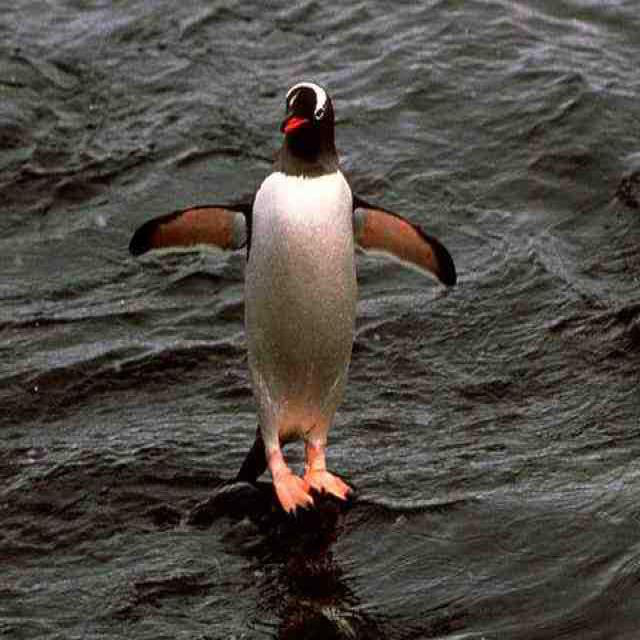

In [9]:
# на Windows могло распаковаться как папка в папке, если файл не найден, то
# путь train_penguin/train_penguin/penguin_image_id_001.jpg

image02 = Image.open('train_penguin/penguin_image_id_001.jpg')
image02

Посмотрим и на его характеристики:

In [10]:
print(image02.format)
print(image02.size)
print(image02.mode)

JPEG
(640, 640)
RGB


Проблема: для корректного обучения нам потребуются изображения одинакового размера, а у нас они разные из разных источников (изображения с чайками [отсюда](https://www.kaggle.com/datasets/kedarsai/bird-species-classification-220-categories), а изображения с пингвинами – [отсюда](https://www.kaggle.com/datasets/abbymorgan/penguins-vs-turtles)). Это решаемо, размер можно менять с помощью метода `.resize()`:

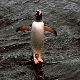

In [11]:
# 80 на 80

image02.resize((80, 80))

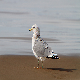

In [12]:
image01.resize((80, 80))

### Подготовка тренировочной и тестовой выборки 

Приступим к формированию тренировочной и тестовой выборок. Для этого нам нужно все изображения в папках превратить в числовой вид. 
Напишем функцию для преобразования одного изображения в числовой одномерный массив (с учетом того, что изображения могут быть разного размера):

In [13]:
def resize_and_pixelize(path):
    """
    Resizes an image to (640, 640) in pixels.
    Parameters: 
        – path: a path to jpeg;
    Returns a NumPy array of floats of shape (1228800,). 
    
    """
    # open path and load image, resize it
    
    image = Image.open(path)
    image_upd = image.resize((640, 640))
    
    # convert to array
    # return a flattened 1d array
    
    np_img = np.array(image_upd, dtype = float)
    return np_img.flatten()

Проверим её работу:

In [14]:
# или train_penguin/train_penguin/penguin_image_id_001.jpg

resize_and_pixelize('train_penguin/penguin_image_id_001.jpg')

array([91., 91., 91., ..., 73., 64., 59.])

Теперь применим эту функцию ко всем файлам в папках с тренировочными и тестовыми изображениями, чтобы получить массивы вместо картинок!
Начнём с папки `train_seagull`. Воспользуемся функцией `listdir()` из модуля `os`, которая возвращает список названий файлов, лежащих в папке:

In [15]:
# или train_seagull/train_seagull/

gull_train = "train_seagull/"
gull_train_files = os.listdir(gull_train)
print(gull_train_files[0:3]) # несколько элементов для примера

['California_Gull_0029_41506.jpg', 'Western_Gull_0073_54118.jpg', 'California_Gull_0027_41083.jpg']


Так как иногда (особенно на Mac) образуются скрытые вспомогательные системные файлы, на всякий случай отфильтруем список, чтобы в нём остались только названия с расширением `.jpg`:

In [16]:
# filter(lambda-function, list)
# применяем lambda-функцию, которая возвращает True/False, к элементам списка gull_train_files,
# возвращает скрытый объект, превращаем его в список list

gull_train_files = list(filter(lambda x: x.endswith(".jpg"), gull_train_files))

Для удобства формируем полные пути к изображениям – склеиваем их названия с названием папки:

In [17]:
gull_train_paths = [gull_train + f for f in gull_train_files]
print(gull_train_paths[0:3])

['train_seagull/California_Gull_0029_41506.jpg', 'train_seagull/Western_Gull_0073_54118.jpg', 'train_seagull/California_Gull_0027_41083.jpg']


Теперь применяем написанную нами функцию `resize_and_pixelize()` к каждому элементу списка `gull_train_paths`, используя конструкцию с `map()` вместо цикла:

In [18]:
g_train_x = list(map(lambda x: resize_and_pixelize(x), gull_train_paths))

# проверим, что получилось
print(len(g_train_x), g_train_x[0])

95 [143. 153. 163. ... 107. 106. 104.]


Получился список `g_train_x` из 95 одномерных массивов, у нас есть числовые массивы для обучения на 95 изображениях с чайками. Теперь проделаем то же самое для изображений с пингвинами в папке `train_penguin`:

In [19]:
# или train_penguin/train_penguin/

pin_train = "train_penguin/"
pin_train_files = os.listdir(pin_train)
pin_train_files = list(filter(lambda x: x.endswith(".jpg"), pin_train_files))
pin_train_paths = [pin_train + f for f in pin_train_files]

In [20]:
p_train_x = list(map(lambda x: resize_and_pixelize(x), pin_train_paths))
print(len(p_train_x), p_train_x[0])

89 [255. 255. 255. ... 255. 255. 255.]


Теперь у нас есть ещё 89 массивов для обучения на изображениях с пингвинами. Массивы с чайками и пингвинами нужно объединить в одну обучающую выборку. Поступим просто – склеим списки `g_train_x` и `p_train_x` через `+`, а затем превратим общий список в массив с помощью функции `.asarray()`:

In [21]:
train_X = np.asarray(g_train_x + p_train_x)
print(train_X.shape) # всего 184 изображения закодированных 1228800 числами 

(184, 1228800)


Почему изображения закодированы 1228800 числами? Каждое изображение 640 на 640 пикселей, один пиксель описывается тремя числами – кодами RGB, итого: 

In [22]:
640 * 640 * 3

1228800

Массив с закодированными изображениями у нас есть, это наша входная (независимая) переменная `X`. Осталось зафиксировать значения целевой (зависимой) переменной `Y`, то есть метки классов `Gull` и `Penguin`. В массиве `train_X` сначала идут чайки, затем – пингвины, повторим слова `Gull` и `Penguin` нужное число раз и преобразуем полученный список в массив:

In [27]:
train_Y = np.asarray(["Gull"] * len(g_train_x) + ["Penguin"] * len(p_train_x))
print(train_Y.shape) # просто массив из 184 названий

(184,)


Проделаем аналогичные операции для формирования тестовой выборки:

In [30]:
# чайки – тестовые данные
# или test_seagull/test_seagull/

gull_test = "test_seagull/"
gull_test_files = os.listdir(gull_test)
gull_test_files = list(filter(lambda x: x.endswith(".jpg"), gull_test_files))
gull_test_paths = [gull_test + f for f in gull_test_files]

g_test_x = list(map(lambda x: resize_and_pixelize(x), gull_test_paths))
print(len(g_test_x), g_test_x[0])

24 [83. 88. 94. ... 21. 38. 48.]


In [29]:
# пингвины – тестовые данные
# или test_penguin/test_penguin/

pin_test = "test_penguin/"
pin_test_files = os.listdir(pin_test)
pin_test_files = list(filter(lambda x: x.endswith(".jpg"), pin_test_files))
pin_test_paths = [pin_test + f for f in pin_test_files]

p_test_x = list(map(lambda x: resize_and_pixelize(x), pin_test_paths))
print(len(p_test_x), p_test_x[0])

23 [255. 255. 255. ... 255. 255. 255.]


In [31]:
# объединяем

test_X = np.asarray(g_test_x + p_test_x)
test_Y = np.asarray(["Gull"] * len(g_test_x) + ["Penguin"] * len(p_test_x))

print(test_X.shape)
print(test_Y.shape)

(47, 1228800)
(47,)


Готово! Для работы у нас есть:

* признаки и целевая переменная для обучения алгоритма (массивы `train_X`, `train_Y`);
* признаки и целевая переменная для тестирования качества алгоритма (массивы `test_X` `test_Y`).

### Обучение и тестирование алгоритма: метод k-ближайших соседей

Импортируем функции для реализации метода k-ближайших соседей и вычисления метрик для проверки качества классификации: 

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Создаём объект `neigh` класса `KNeighborsClassifier` – резервируем место для результатов обучения алгоритма на данных, считая, что нам будет достаточно трёх ближайших соседей:

In [33]:
neigh = KNeighborsClassifier(n_neighbors = 3)

Запускаем обучение алгоритма, сначала помещаем массив с входными признаками `train_X`, затем – с целевой переменной `train_Y`:

In [34]:
neigh.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Настройки нас устраивают: метрика Минковского с `p=2` – это обычное евклидово расстояние, подходит для числовых данных, алгоритм по умолчанию и так будет выбран оптимальный для нашей ситуации. 

Модель, которая позволяет предсказывать метки изображений (*Gull* или *Penguin*), сохранена в `neigh`. Воспользуемся методом `.predict()`, чтобы предсказать классы картинок в `test_X`:

In [35]:
predicted = neigh.predict(test_X)

In [36]:
predicted

array(['Gull', 'Gull', 'Gull', 'Gull', 'Gull', 'Penguin', 'Gull', 'Gull',
       'Gull', 'Penguin', 'Gull', 'Gull', 'Penguin', 'Gull', 'Gull',
       'Gull', 'Gull', 'Gull', 'Gull', 'Penguin', 'Gull', 'Gull', 'Gull',
       'Penguin', 'Penguin', 'Penguin', 'Gull', 'Penguin', 'Penguin',
       'Penguin', 'Penguin', 'Penguin', 'Penguin', 'Penguin', 'Penguin',
       'Penguin', 'Gull', 'Penguin', 'Penguin', 'Penguin', 'Penguin',
       'Penguin', 'Penguin', 'Gull', 'Gull', 'Penguin', 'Penguin'],
      dtype='<U7')

Сравним классы, предсказанные моделью в `predicted`, с настоящими классами в `test_Y`, построив *confusion matrix* – матрицу соответствий:

In [37]:
# labels – чтобы точно знать, какое значение класса первое в строке/столбце

confusion_matrix(test_Y, predicted, labels = ["Gull", "Penguin"])

array([[19,  5],
       [ 4, 19]])

Для наглядности сделаем её маленькой таблицей с подписями:

In [38]:
import pandas as pd

In [39]:
pd.DataFrame(confusion_matrix(test_Y, predicted, labels = ["Gull", "Penguin"]), 
            index = ["True Gull", "True Penguin"], 
            columns = ["Predicted Gull", "Predicted Penguin"])

,Predicted Gull,Predicted Penguin
True Gull,19,5
True Penguin,4,19


Наша модель ошиблась на тестовых данных 9 раз: 

* 5 раз сообщила, что на картинке пингвин, когда там была чайка;
* 4 раза сообщила, что на картинке чайка, когда там был пингвин.

Вычислим точность модели (*accuracy)* – долю верно предсказанных классов:

In [40]:
print("Accuracy: ", accuracy_score(test_Y, predicted))

Accuracy:  0.8085106382978723


Точность мы могли бы посчитать вручную по таблице, получили бы такой же результат:

In [41]:
(19 + 19) / (19 + 5 + 4 + 19)

0.8085106382978723

Если хотим понять, на каких изображениях модель ошиблась, можно сравнить массивы `test_Y` и `predicted`:

In [42]:
# сравниваем поэлементно
# True – настоящее значение и предсказанное моделью не совпадают

test_Y != predicted

array([False, False, False, False, False,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True,  True,
       False, False])

In [43]:
# забираем те, где значения не 0 (False = 0 как обычно)
# метод .nonzero() возвращает индексы ненулевых элементов

(test_Y != predicted).nonzero()

(array([ 5,  9, 12, 19, 23, 26, 36, 43, 44]),)

Выберем названия этих изображений:

In [44]:
# найдем и подумаем, почему модель ошибается

all_paths = gull_test_paths + pin_test_paths
for i in [5, 9, 12, 19, 23, 26, 36, 43, 44]:
    print(all_paths[i]) 

test_seagull/California_Gull_0026_41386.jpg
test_seagull/Western_Gull_0090_53603.jpg
test_seagull/California_Gull_0053_41011.jpg
test_seagull/Western_Gull_0022_54607.jpg
test_seagull/California_Gull_0012_41272.jpg
test_penguin/penguin_image_id_449.jpg
test_penguin/penguin_image_id_447.jpg
test_penguin/penguin_image_id_451.jpg
test_penguin/penguin_image_id_069.jpg


Если попытаться найти что-то общее в этих изображениях, мы придем к тому, что это картинки с противоречивым фоном: либо фон у пингвина пестрый, похож на берег, на котором обычно встречаются чайки, либо картинки не очень контрастные, непонятно, какой цвет преобладает. 

### Ещё больше предсказаний: немного несерьёзности

Иногда модели, обученные на характеристиках некоторых объектов, можно использовать для предсказания классов других объектов, если между ними существует некоторое сходство. Так, модель, обученную на постах одной социальной сети, можно использовать для предсказания типов постов в другой социальной сети. Что будет, если мы попытаемся наш классификатор, сохраненный в `neigh` применить к изображениям с «ненастоящими» пингвинами, например, нарисованными? 

Возьмем кадр с Пином из «Смешариков»:

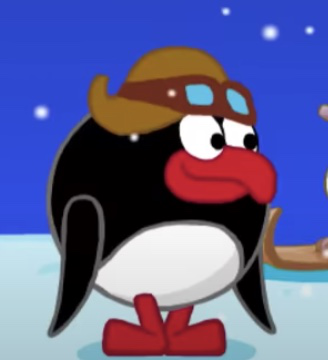

In [45]:
pred01 = Image.open('Pin.jpeg')
pred01

Превратим картинку в массив:

In [46]:
one = resize_and_pixelize("Pin.jpeg")
one

array([ 45.,  70., 199., ..., 171., 198., 207.])

Поместим его в метод `predict()` для предсказания класса:

In [ ]:
# нужно изменение размерности – predict() ожидает на входе двумерную таблицу
# до reshape array([ 45.,  70., 199., ..., 171., 198., 207.])
# после reshape array([[ 45.,  70., 199., ..., 171., 198., 207.]])

neigh.predict(one.reshape(1, -1))

Наш классификатор верно определил, что Пин – это пингвин! Однако результат тут во многом определяется фоном, если взять кадр с Пином из какой-нибудь летней серии на пестром или зеленом фоне, модель его назовет чайкой :(

Попробуем потестить классификатор на более радикальном примере – люди в костюмах пингвинов! Возьмем фото со [спектакля](https://teatr-uz.ru/u-kovchega-v-vosem) «У ковчега в восемь» (Театр на Юго-Западе) по пьесе Ульриха Хуба «Ковчег отходит ровно в восемь» о двух пингвинах, которые протащили на Ноев ковчег своего третьего друга:

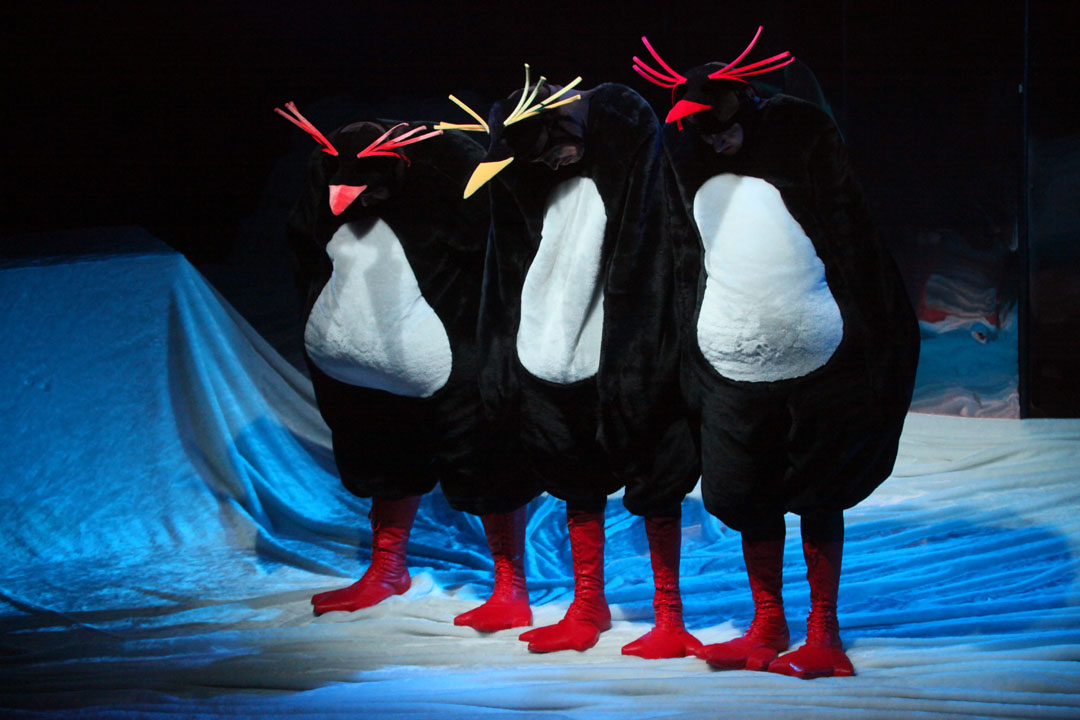

In [49]:
pred02 = Image.open('10.jpeg')
pred02

In [50]:
two = resize_and_pixelize("10.jpeg")
neigh.predict(two.reshape(1, -1))

array(['Gull'], dtype='<U7')

Вот тут наш алгоритм ошибается, все-таки пингвинов трое и само фото более «сложное» по цветам и композиции. 

P.S. Кто загрустил от работы с изображениями и метода k-ближайших соседей, можно послушать [грустную](https://www.youtube.com/watch?v=mFmJugB4-Aw) песню пингвинов.